In [1]:
import pandas as pd

df = pd.read_csv('profiles.csv')

print(df.describe())
print(df.info())
df.head()

                age        height          income
count  59946.000000  59943.000000    59946.000000
mean      32.340290     68.295281    20033.222534
std        9.452779      3.994803    97346.192104
min       18.000000      1.000000       -1.000000
25%       26.000000     66.000000       -1.000000
50%       30.000000     68.000000       -1.000000
75%       37.000000     71.000000       -1.000000
max      110.000000     95.000000  1000000.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       503

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


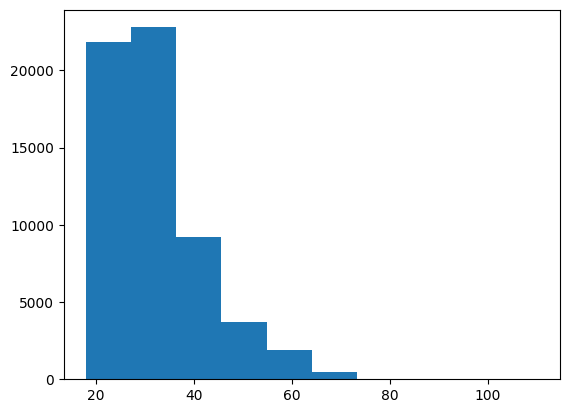

In [2]:
import matplotlib.pyplot as plt
#EDA

#age column
plt.hist(df['age'])
plt.show() 

#based on the histogram, let's consider that everything above 80 years an outlier and drop those rows
df = df[df['age'] < 80]

In [3]:
#body type
print(df['body_type'].value_counts(normalize = True))
# 3 groups with ~20% of the answers each. All the others have less than 10%. Will keep those 3 and aggregate the others

map_body_type = {
    'average': 'average',
    'fit': 'fit', 
    'athletic': 'athletic',  
    'thin': 'other', 
    'curvy': 'other',
    'a little extra': 'other',  
    'skinny': 'other', 
    'full figured': 'other',  
    'overweight': 'other',  
    'jacked': 'other', 
    'used up': 'unknown',  
    'rather not say': 'unknown'
}

df['body_type'] = df['body_type'].map(map_body_type).fillna('unknown')
print(df['body_type'].value_counts(normalize = True))

body_type
average           0.268111
fit               0.232593
athletic          0.216253
thin              0.086205
curvy             0.071804
a little extra    0.048107
skinny            0.032517
full figured      0.018463
overweight        0.008125
jacked            0.007704
used up           0.006496
rather not say    0.003623
Name: proportion, dtype: float64
body_type
other       0.248816
average     0.244428
fit         0.212048
athletic    0.197151
unknown     0.097558
Name: proportion, dtype: float64


In [4]:
#diet
print(df['diet'].value_counts(normalize = True))

map_diet = {
    # Group 1: Anything
    'mostly anything': 'anything',
    'anything': 'anything',
    'strictly anything': 'anything',
    
    # Group 2: Vegetarian/Vegan
    'vegetarian': 'vegetarian',
    'mostly vegetarian': 'vegetarian',
    'strictly vegetarian': 'vegetarian',
    'vegan': 'vegetarian',
    'mostly vegan': 'vegetarian',
    'strictly vegan': 'vegetarian',
    
    # Group 3: Other (includes religious-based + remaining 'other')
    'other': 'other',
    'mostly other': 'other',
    'strictly other': 'other',
    'kosher': 'other',
    'mostly kosher': 'other',
    'strictly kosher': 'other',
    'halal': 'other',
    'mostly halal': 'other',
    'strictly halal': 'other'
}

df['diet'] = df['diet'].map(map_diet).fillna('unknown')
print(df['diet'].value_counts(normalize = True))

#religious diets have a low percentage, so they were merged into the other group

diet
mostly anything        0.466526
anything               0.173924
strictly anything      0.143826
mostly vegetarian      0.096878
mostly other           0.028298
strictly vegetarian    0.024613
vegetarian             0.018762
strictly other         0.012714
mostly vegan           0.009508
other                  0.009311
strictly vegan         0.006414
vegan                  0.003826
mostly kosher          0.002419
mostly halal           0.001350
strictly halal         0.000506
strictly kosher        0.000506
halal                  0.000309
kosher                 0.000309
Name: proportion, dtype: float64
diet
anything      0.465117
unknown       0.406946
vegetarian    0.094889
other         0.033048
Name: proportion, dtype: float64


In [5]:
#drinks
print(df['drinks'].value_counts(normalize = True))

map_drinks = {
    'socially': 'socially',
    'rarely': 'light',
    'not at all': 'light',
    'often': 'heavy',
    'very often': 'heavy',
    'desperately': 'heavy'
}
df['drinks'] = df['drinks'].map(map_drinks).fillna('unknown')

#socially category dominates with 70%
print(df['drinks'].value_counts(normalize = True))

drinks
socially       0.733484
rarely         0.104580
often          0.090659
not at all     0.057355
very often     0.008269
desperately    0.005653
Name: proportion, dtype: float64
drinks
socially    0.696984
light       0.153877
heavy       0.099376
unknown     0.049763
Name: proportion, dtype: float64


In [6]:
#drugs
print(df['drugs'].value_counts(normalize = True))

map_drugs = {
    'never': 'no',
    'sometimes': 'yes',
    'often': 'yes',
    'unknown': 'unknown'
}

df['drugs'] = df['drugs'].map(map_drugs).fillna('unknown')

print(df['drugs'].value_counts(normalize = True))


drugs
never        0.822479
sometimes    0.168582
often        0.008939
Name: proportion, dtype: float64
drugs
no         0.629304
unknown    0.234869
yes        0.135827
Name: proportion, dtype: float64


In [7]:
import numpy as np

#education
print(df['education'].value_counts(normalize = True))

education_level_conditions = [
    df['education'].str.contains('college', case = False, na=False),
    df['education'].str.contains('masters', case = False, na=False),
    df['education'].str.contains('high school|ph.d|law school|med school', case = False, na=False) #these represent a low percentage <5%, so will group them
]

education_level_choices = ['college', 'masters', 'other']

df['education'] = np.select(education_level_conditions, education_level_choices, default = 'unknown')
print(df['education'].value_counts(normalize = True))

education
graduated from college/university    0.449369
graduated from masters program       0.168070
working on college/university        0.107133
working on masters program           0.031547
graduated from two-year college      0.028715
graduated from high school           0.026783
graduated from ph.d program          0.023857
graduated from law school            0.021044
working on two-year college          0.020144
dropped out of college/university    0.018662
working on ph.d program              0.018437
college/university                   0.015023
graduated from space camp            0.012323
dropped out of space camp            0.009809
graduated from med school            0.008365
working on space camp                0.008346
working on law school                0.005045
two-year college                     0.004164
working on med school                0.003976
dropped out of two-year college      0.003582
dropped out of masters program       0.002626
masters program         

In [8]:
#ethnicity
print(df['ethnicity'].value_counts(normalize = True))

#white dominates with 60%, asian is the only other with more than 10%. Will keep the 2 and aggregate all the others into 'other'

ethnicity_conditions = [
    df['ethnicity'] == 'white',
    df['ethnicity'] == 'asian',
    df['ethnicity'].isna()
]

ethnicity_choices = ['white', 'asian', 'unknown']

df['ethnicity'] = np.select(ethnicity_conditions, ethnicity_choices, default = 'other')
print(df['ethnicity'].value_counts(normalize = True))

ethnicity
white                                                                               0.605001
asian                                                                               0.113036
hispanic / latin                                                                    0.052022
black                                                                               0.037003
other                                                                               0.031438
                                                                                      ...   
asian, black, pacific islander, hispanic / latin, white                             0.000018
asian, native american, indian, pacific islander, hispanic / latin, white, other    0.000018
asian, middle eastern, black, pacific islander, hispanic / latin                    0.000018
asian, black, pacific islander, white, other                                        0.000018
asian, black, indian                                        

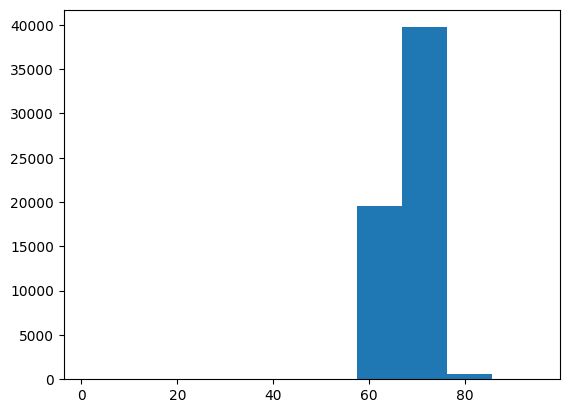

In [9]:
#height
plt.hist(df['height'])
plt.show()
df = df[(df['height'] >= 50) & (df['height'] <= 90)] #reasonable interval for height


income
-1          0.808256
 20000      0.049226
 100000     0.027068
 80000      0.018535
 30000      0.017483
 40000      0.016782
 50000      0.016264
 60000      0.012290
 70000      0.011806
 150000     0.010503
 1000000    0.008499
 250000     0.002488
 500000     0.000802
Name: proportion, dtype: float64


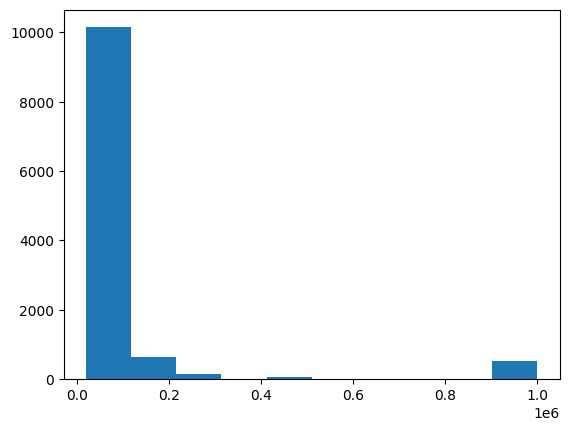

income
unknown    0.808256
high       0.091990
medium     0.050528
low        0.049226
Name: proportion, dtype: float64


In [10]:
#income
print(df['income'].value_counts(normalize = True))
# 80% of unknowns, not a great column to predict other columns, but might be fun to remove the unknowns and predict this one

df_income = df[df['income'] > 0]
plt.hist([df_income['income']])
plt.show()

def classify_income(i):
    if i <= 0:
        return 'unknown'
    elif i <= 20000:
        return 'low'
    elif i <= 50000:
        return 'medium'
    else: 
        return 'high'

df['income'] = df['income'].apply(classify_income)

print(df['income'].value_counts(normalize = True))

In [11]:
#job
print(df['job'].value_counts(normalize = True))
#will group into bigger categories

job_map = {
    # STEM/Technical
    'science / tech / engineering': 'stem',
    'computer / hardware / software': 'stem',

    # Creative/Artistic
    'artistic / musical / writer': 'creative',
    'entertainment / media': 'creative',

    # Business/Professional
    'sales / marketing / biz dev': 'business',
    'executive / management': 'business',
    'banking / financial / real estate': 'business',
    'law / legal services': 'business',

    # Education/Health
    'education / academia': 'education_health',
    'medicine / health': 'education_health',

    # Manual Labor / Skilled Trades - Not enough percentage to create its own category
    'construction / craftsmanship': 'other',
    'transportation': 'other',
    'clerical / administrative': 'other',

    # Public/Government - Not enough percentage to create its own category
    'political / government': 'other',
    'military': 'other',

    # Other groups
    'student': 'student',
    'unemployed': 'other',
    'retired': 'other',
    'rather not say': 'unknown',
    'hospitality / travel': 'other',
    'other': 'other'
}

df['job'] = df['job'].map(job_map).fillna('unknown')
print(df['job'].value_counts(normalize = True))

job
other                                0.146692
student                              0.094281
science / tech / engineering         0.093701
computer / hardware / software       0.091013
artistic / musical / writer          0.085772
sales / marketing / biz dev          0.084901
medicine / health                    0.071151
education / academia                 0.067882
executive / management               0.045855
banking / financial / real estate    0.043805
entertainment / media                0.043476
law / legal services                 0.026670
hospitality / travel                 0.026360
construction / craftsmanship         0.019746
clerical / administrative            0.015568
political / government               0.013673
rather not say                       0.008374
transportation                       0.007078
unemployed                           0.005260
retired                              0.004816
military                             0.003926
Name: proportion, dtype: float

In [12]:
#last online
print(df['last_online'].value_counts(normalize = True))

df['last_online'] = pd.to_datetime(df['last_online'], format='%Y-%m-%d-%H-%M')
most_recent_date = df['last_online'].max() #will assume the max day as today
df['last_online'] = (most_recent_date - df['last_online']).dt.days

#binary distribution into active or not active. 
def categorize_last_online(v):
    if v <= 3:
        return 'active'
    else:
        return 'not active'

df['last_online'] = df['last_online'].apply(categorize_last_online)
df.rename(columns={'last_online': 'presence'}, inplace=True)
print(df['presence'].value_counts(normalize = True))

last_online
2012-06-29-22-56    0.000401
2012-06-30-21-51    0.000384
2012-06-30-22-56    0.000384
2012-06-30-23-27    0.000384
2012-06-30-22-09    0.000384
                      ...   
2011-07-10-08-31    0.000017
2012-01-24-05-43    0.000017
2012-03-11-20-40    0.000017
2012-06-27-10-31    0.000017
2012-06-14-16-51    0.000017
Name: proportion, Length: 30097, dtype: float64
presence
active        0.509042
not active    0.490958
Name: proportion, dtype: float64


In [13]:
#location
print(df['location'].value_counts(normalize = True))
#50% of the cities is san francisco, so will do this and 'other'
#a big percentage is California, so will ignore the data about the state

def get_city(location):
    city = location.split(',')[0]
    if city == 'san francisco': 
        return city
    else:
        return 'other'

df['city'] = df['location'].apply(get_city)
df.drop(columns='location', inplace=True)
print(df['city'].value_counts(normalize = True))

location
san francisco, california    0.518176
oakland, california          0.120393
berkeley, california         0.070232
san mateo, california        0.022175
palo alto, california        0.017767
                               ...   
denver, colorado             0.000017
seattle, washington          0.000017
cincinnati, ohio             0.000017
phoenix, arizona             0.000017
rochester, michigan          0.000017
Name: proportion, Length: 198, dtype: float64
city
san francisco    0.518176
other            0.481824
Name: proportion, dtype: float64


In [14]:
#offspring
df['offspring'] = df['offspring'].fillna('unknown')
print(df['offspring'].value_counts(normalize = True))

df['offspring'] = df['offspring'].str.replace("doesn&rsquo;t", "doesn't", regex=False)

has_kids_conditions = [
    df['offspring'].str.contains('has a kid|has kids', case = False),
    df['offspring'].str.contains('doesn\'t have kids', case = False)
]

has_kids_choices = ['yes', 'no']

df['has_kids'] = np.select(has_kids_conditions, has_kids_choices, default = 'unknown')

wants_kids_conditions = [
    df['offspring'].str.contains('doesn\'t want', case=False),
    df['offspring'].str.contains('might want', case=False),
    df['offspring'].str.contains('wants', case=False)
]
 
wants_kids_choices = ['no', 'maybe', 'yes']

df['wants_kids'] = np.select(wants_kids_conditions, wants_kids_choices, default='unknown')
df.drop(columns='offspring', inplace=True)

print(df['wants_kids'].value_counts(normalize = True))
print(df['has_kids'].value_counts(normalize = True))

offspring
unknown                                                0.593134
doesn&rsquo;t have kids                                0.126087
doesn&rsquo;t have kids, but might want them           0.064688
doesn&rsquo;t have kids, but wants them                0.059529
doesn&rsquo;t want kids                                0.048809
has a kid                                              0.031409
has kids                                               0.031392
doesn&rsquo;t have kids, and doesn&rsquo;t want any    0.018902
has kids, but doesn&rsquo;t want more                  0.007381
has a kid, but doesn&rsquo;t want more                 0.004575
has a kid, and might want more                         0.003857
wants kids                                             0.003757
might want kids                                        0.003022
has kids, and might want more                          0.001920
has a kid, and wants more                              0.001186
has kids, and wants more      

In [15]:
#orientation
print(df['orientation'].value_counts(normalize = True))

#will join gay and bisexual to make it less imbalanced
map_orientation = {
    'straight': 'straight',
    'gay': 'queer',
    'bisexual': 'queer'
}

df['orientation'] = df['orientation'].map(map_orientation).fillna('unknown')

print(df['orientation'].value_counts(normalize = True))

orientation
straight    0.860821
gay         0.093025
bisexual    0.046154
Name: proportion, dtype: float64
orientation
straight    0.860821
queer       0.139179
Name: proportion, dtype: float64


In [16]:
#pets
print(df['pets'].value_counts(normalize = True))
df['pets'] = df['pets'].fillna('unknown')

def likes_dogs(pets):
    if isinstance(pets, str):
        pets = pets.lower().strip()
        if 'likes dogs' in pets or 'has dogs' in pets:
            return 'yes'
    return 'no'

def likes_cats(pets):
    if isinstance(pets, str):
        pets = pets.lower().strip()
        if 'likes cats' in pets or 'has cats' in pets:
            return 'yes'
    return 'no'
        

df['likes_dogs'] = df['pets'].apply(likes_dogs)
df['likes_cats'] = df['pets'].apply(likes_cats)
df.drop(columns='pets', inplace=True)

print(df['likes_dogs'].value_counts(normalize = True))
print(df['likes_cats'].value_counts(normalize = True))

pets
likes dogs and likes cats          0.370120
likes dogs                         0.180584
likes dogs and has cats            0.107760
has dogs                           0.103309
has dogs and likes cats            0.058219
likes dogs and dislikes cats       0.050741
has dogs and has cats              0.036837
has cats                           0.035111
likes cats                         0.026559
has dogs and dislikes cats         0.013754
dislikes dogs and likes cats       0.005952
dislikes dogs and dislikes cats    0.004877
dislikes cats                      0.003051
dislikes dogs and has cats         0.002026
dislikes dogs                      0.001100
Name: proportion, dtype: float64
likes_dogs
yes    0.624493
no     0.375507
Name: proportion, dtype: float64
likes_cats
no     0.522584
yes    0.477416
Name: proportion, dtype: float64


In [17]:
#religion
df['religion'] = df['religion'].fillna('unknown')
print(df['religion'].value_counts(normalize = True))

def get_religion(r):
    try:
        religion = r.split(' ')[0]
    except:
        print(r)
        return
    if religion == 'buddhism' or religion == 'hinduism' or religion == 'islam':
        return 'other'
    else:
        return religion

religion_importance_conditions = [
    df['religion'].str.contains('not too serious|laughing', case=False, na=False),
    df['religion'].str.contains('somewhat serious|very serious', case=False, na=False),
    df['religion'].str.contains('unknown', case=False, na=False)
]

religion_importance_options = ['no', 'yes', 'unknown']

df['religion_importance'] = np.select(religion_importance_conditions, religion_importance_options, default = 'unknown')
df['religion'] = df['religion'].apply(get_religion)   

print(df['religion'].value_counts(normalize = True))
print(df['religion_importance'].value_counts(normalize = True))


religion
unknown                                       0.337369
agnosticism                                   0.045452
other                                         0.044918
agnosticism but not too serious about it      0.044000
agnosticism and laughing about it             0.041645
catholicism but not too serious about it      0.038706
atheism                                       0.036302
other and laughing about it                   0.035266
atheism and laughing about it                 0.034582
christianity                                  0.032645
christianity but not too serious about it     0.032545
other but not too serious about it            0.025915
judaism but not too serious about it          0.025314
atheism but not too serious about it          0.022008
catholicism                                   0.017767
christianity and somewhat serious about it    0.015479
atheism and somewhat serious about it         0.014160
other and somewhat serious about it           0.014110
c

In [18]:
#sex - good to go

print(df['sex'].value_counts(normalize=True))

sex
m    0.597642
f    0.402358
Name: proportion, dtype: float64


In [19]:
#sign
df['sign'] = df['sign'].fillna('unknown')
df['sign'] = df['sign'].str.replace('&rsquo;', '\'', regex=False)

def get_sign(sign):
    if isinstance(sign, str):
        return sign.split(' ')[0]
    else:
        return 'unknown'

sign_importance_conditions = [
    df['sign'].str.contains('fun', regex = False),
    df['sign'].str.contains('but it doesn\'t matter', regex = False),
    df['sign'].str.contains('and it matters a lot', regex = False)
]

sign_importance_options = ['fun', 'not important', 'important']

df['sign_importance'] = np.select(sign_importance_conditions, sign_importance_options, default = 'unknown')
df['sign'] = df['sign'].apply(get_sign)

print(df['sign'].value_counts(normalize=True, dropna=False))
print(df['sign_importance'].value_counts(normalize=True, dropna=False))  


sign
unknown        0.184280
leo            0.072937
gemini         0.071919
libra          0.070216
cancer         0.070199
virgo          0.069130
taurus         0.069047
scorpio        0.068980
aries          0.066575
pisces         0.065841
sagittarius    0.065757
aquarius       0.065507
capricorn      0.059612
Name: proportion, dtype: float64
sign_importance
unknown          0.386595
fun              0.322624
not important    0.279560
important        0.011221
Name: proportion, dtype: float64


In [20]:
#smokes
df['smokes'] = df['smokes'].fillna('unknown')
print(df['smokes'].value_counts(normalize=True, dropna=False))

smokes_map = {
    'no': 'no',
    'unknown': 'unknown',
    'sometimes': 'yes',
    'when drinking': 'yes',
    'trying to quit': 'yes',
    'yes': 'yes'
}

df['smokes'] = df['smokes'].map(smokes_map)

print(df['smokes'].value_counts(normalize=True, dropna=False))

smokes
no                0.732480
unknown           0.091823
sometimes         0.063169
when drinking     0.050679
yes               0.037153
trying to quit    0.024697
Name: proportion, dtype: float64
smokes
no         0.732480
yes        0.175698
unknown    0.091823
Name: proportion, dtype: float64


In [21]:
#speaks

df['speaks'] = df['speaks'].fillna('unknown')
print(df['speaks'].value_counts(normalize=True, dropna=False))

#speaks - has a list of comma separated values with proficiency between brackets
# will get the top 5 languages and save the proficiency level for each + add a column for languages count

def get_languages_count(l):
    count_commas = l.count(',')
    return (count_commas + 1)

df['language_count'] = df['speaks'].apply(get_languages_count)
#print(df['language_count'].value_counts(normalize=True, dropna=False))

language_counts = {}
def get_top_languages(lang):
    languages = lang.split(',')
    for language in languages:
        l = language.strip().split(' ')[0]
        if l in language_counts:
            language_counts[l] += 1
        else:
            language_counts[l] = 1

df['speaks'].apply(get_top_languages)
top_5_languages = sorted(language_counts, key=language_counts.get, reverse=True)[:5]
print(top_5_languages)

for lang in top_5_languages:
    df[f'{lang}_level'] = 'none'

for idx, row in df['speaks'].items():
    languages = row.split(',')
    for language in languages:
        record = language.strip().split(' ')
        l = record[0].strip().lower()
        if len(record) == 1:
            level = 'okay'
        elif len(record) >= 2:
            level = record[1].strip('()').lower()
        if l in top_5_languages:
            df.at[idx, f'{l}_level'] = level  

df.drop(columns='speaks', inplace=True)

for lang in top_5_languages:    
    print(df[f'{lang}_level'].value_counts(normalize=True, dropna=False))

print(df['language_count'].value_counts(normalize=True, dropna=False))

speaks
english                                                                                         0.364119
english (fluently)                                                                              0.110575
english (fluently), spanish (poorly)                                                            0.034348
english (fluently), spanish (okay)                                                              0.031994
english (fluently), spanish (fluently)                                                          0.021507
                                                                                                  ...   
english, spanish (fluently), hindi (okay), french (poorly)                                      0.000017
english (fluently), polish (fluently), french (poorly), hungarian (poorly), italian (poorly)    0.000017
english (fluently), hindi (poorly), french (poorly), tamil (okay), spanish (poorly)             0.000017
english (fluently), french (poorly), japanese (p

In [22]:
#status
df['status'] = df['status'].fillna('unknown')
print(df['status'].value_counts(normalize=True, dropna=False))

status_map = {
    'single': 'available',
    'seeing someone': 'unavailable',
    'available': 'available',
    'married': 'unavailable',
    'unknown': 'unknown'
}

df['status'] = df['status'].map(status_map)

print(df['status'].value_counts(normalize=True, dropna=False))

status
single            0.929117
seeing someone    0.034432
available         0.031109
married           0.005176
unknown           0.000167
Name: proportion, dtype: float64
status
available      0.960225
unavailable    0.039608
unknown        0.000167
Name: proportion, dtype: float64


In [24]:
import re
import string
import nltk
from nltk.corpus import stopwords    

# Ensure stopwords are downloaded
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess(text):
    try:
        # Ensure it's a string
        if not isinstance(text, str):
            return ""

        # Remove HTML tags
        text = re.sub(r'<.*?>', ' ', text)

        # Lowercase
        text = text.lower()

        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Remove stop words (words that do not have a lot of value (is, are, then, etc...)
        words = text.split()
        filtered = [word for word in words if word not in stop_words]

        return ' '.join(filtered)

    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        return ""
    
    
essay_cols = [col for col in df.columns if 'essay' in col]
df['essays'] = df[essay_cols].fillna('').agg(' '.join, axis=1)
df['essays'] = df['essays'].apply(preprocess)

print(df['essays'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PedroMarques\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    would love think kind intellectual either dumb...
1    chef means 1 workaholic 2 love cook regardless...
2    im ashamed much writing public text online dat...
3    work library go school reading things written ...
4    hey hows going currently vague profile know co...
Name: essays, dtype: object


In [25]:
not_essay_cols = [col for col in df.columns if 'essay' not in col]

for col in not_essay_cols:
    if df[col].dtype in ['object', 'category']:
        print(df[col].value_counts(normalize=True))

df.drop(columns = ['essay0', 'essay1', 'essay2','essay3','essay4','essay5','essay6','essay7','essay8','essay9'], inplace=True)

body_type
other       0.248802
average     0.244561
fit         0.212166
athletic    0.197205
unknown     0.097267
Name: proportion, dtype: float64
diet
anything      0.465260
unknown       0.406833
vegetarian    0.094945
other         0.032962
Name: proportion, dtype: float64
drinks
socially    0.697263
light       0.153957
heavy       0.099187
unknown     0.049593
Name: proportion, dtype: float64
drugs
no         0.629502
unknown    0.234809
yes        0.135689
Name: proportion, dtype: float64
education
college    0.575450
masters    0.182260
unknown    0.138394
other      0.103896
Name: proportion, dtype: float64
ethnicity
white      0.547999
other      0.255030
asian      0.102359
unknown    0.094612
Name: proportion, dtype: float64
income
unknown    0.808256
high       0.091990
medium     0.050528
low        0.049226
Name: proportion, dtype: float64
job
other               0.209912
business            0.173744
stem                0.159484
unknown             0.143821
education_hea

In [26]:
print(df.describe())
print(df.info())
df.head()

                age        height  language_count
count  59887.000000  59887.000000    59887.000000
mean      32.340257     68.299798        1.850518
std        9.443292      3.865486        1.036423
min       18.000000     50.000000        1.000000
25%       26.000000     66.000000        1.000000
50%       30.000000     68.000000        2.000000
75%       37.000000     71.000000        2.000000
max       69.000000     90.000000        5.000000
<class 'pandas.core.frame.DataFrame'>
Index: 59887 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  59887 non-null  int64  
 1   body_type            59887 non-null  object 
 2   diet                 59887 non-null  object 
 3   drinks               59887 non-null  object 
 4   drugs                59887 non-null  object 
 5   education            59887 non-null  object 
 6   ethnicity            59887 non-null  obje

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,likes_cats,religion_importance,sign_importance,language_count,english_level,spanish_level,french_level,chinese_level,german_level,essays
0,22,other,anything,socially,no,college,other,75.0,unknown,other,...,yes,yes,unknown,1,okay,none,none,none,none,would love think kind intellectual either dumb...
1,35,average,other,heavy,yes,unknown,white,70.0,high,other,...,yes,no,unknown,3,fluently,poorly,poorly,none,none,chef means 1 workaholic 2 love cook regardless...
2,38,other,anything,socially,unknown,masters,unknown,68.0,unknown,unknown,...,yes,unknown,not important,3,okay,none,okay,none,none,im ashamed much writing public text online dat...
3,23,other,vegetarian,socially,unknown,college,white,71.0,low,student,...,yes,unknown,unknown,2,okay,none,none,none,poorly,work library go school reading things written ...
4,29,athletic,unknown,socially,no,college,other,66.0,unknown,creative,...,yes,unknown,unknown,1,okay,none,none,none,none,hey hows going currently vague profile know co...


In [27]:
#Train the model

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

def downsample(df, col):
    min_count = df[col].value_counts().min()
    balanced_df = pd.concat([
        df[df[col] == category].sample(n=min_count, random_state=1)
        for category in df[col].unique()
    ])
    return balanced_df

# ----------- Recreate a consistent train/test split ----------- #

print("Starting cell...")

# Create full dataset again for consistent split
full_df = df.copy()
col_to_predict = 'smokes'
full_df = full_df[full_df[col_to_predict] != 'unknown']
full_df = full_df[full_df[col_to_predict].notna()]

print("Starting downsample...")

full_df = downsample(full_df, col_to_predict)

# Label encode target
#le = LabelEncoder()
#full_df[col_to_predict] = le.fit_transform(full_df[col_to_predict])
#y_full = full_df[col_to_predict].values
y_full = full_df[col_to_predict].values

print("Creating cols...")
#create vars with categorical columns and numerical columns
cat_cols = full_df.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [col for col in cat_cols if col != col_to_predict and 'essay' not in col]
num_cols = full_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if col != col_to_predict]

print("Preparing tabular data...")
# Prepare tabular data
df_dummies = pd.get_dummies(full_df[cat_cols], drop_first=True)
X_tab = pd.concat([full_df[num_cols], df_dummies], axis=1)
X_tab = X_tab.reset_index(drop=True)

# Standard scale numeric columns
scaler = StandardScaler()
if len(num_cols) > 0: # check if there are numerical columns
    X_tab[num_cols] = scaler.fit_transform(X_tab[num_cols])

# Prepare text data
X_text = full_df['essays'].fillna("").reset_index(drop=True)

print("Starting split...")

# ----------- Consistent split using index ----------- #

idx_train, idx_test = train_test_split(np.arange(len(full_df)), test_size=0.2, stratify=y_full, random_state=42)

X_tab_train, X_tab_test = X_tab.iloc[idx_train], X_tab.iloc[idx_test]
X_text_train, X_text_test = X_text.iloc[idx_train], X_text.iloc[idx_test]
y_train, y_test = y_full[idx_train], y_full[idx_test]

# ----------- Train Stacking Model (Tabular) ----------- #

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

print("Starting stacking cell...")

base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    #('et', ExtraTreesClassifier(n_estimators=100)),
    #('dt', DecisionTreeClassifier()),
    #('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
]

meta_tabular = LogisticRegression(max_iter=1000)
stack = StackingClassifier(estimators=base_models, final_estimator=meta_tabular, cv=5, n_jobs=-1, passthrough=True)

stack.fit(X_tab_train, y_train)
y_pred = stack.predict(X_tab_test)
stack_score = classification_report(y_test, y_pred)
print('Classification report for stacking:')
print(stack_score)


# ----------- Train Text Model (Naive Bayes) ----------- #
print("Starting text stacking cell...")

text_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', max_features=5000)),
    ('nb', MultinomialNB())
])

text_pipeline.fit(X_text_train, y_train)
y_pred = text_pipeline.predict(X_text_test)
text_pipeline_score = classification_report(y_test, y_pred)
print('Classification report for text stacking:')
print(text_pipeline_score)

# ----------- Generate meta-features ----------- #
print("Starting meta features cell...")
# Probabilities from stack model
pred_tab_train = stack.predict_proba(X_tab_train)  # shape [n_samples, n_classes]
pred_tab_test = stack.predict_proba(X_tab_test)

# Probabilities from text model
pred_text_train = text_pipeline.predict_proba(X_text_train)
pred_text_test = text_pipeline.predict_proba(X_text_test)

# Stack horizontally
X_meta_train = np.hstack((pred_tab_train, pred_text_train))
X_meta_test = np.hstack((pred_tab_test, pred_text_test))

# ----------- Train Final Meta-Model ----------- #

final_meta_model = LogisticRegression(max_iter=1000) #model that will analyze all answers and choose a final one
final_meta_model.fit(X_meta_train, y_train)

# ----------- Evaluate ----------- #

final_preds = final_meta_model.predict(X_meta_test)
print('🔍 Classification Report for double stacking:')
print(classification_report(y_test, final_preds, target_names=sorted(set(y_test))))


Starting cell...
Starting downsample...
Creating cols...
Preparing tabular data...
Starting split...
Starting stacking cell...
Classification report for stacking:
              precision    recall  f1-score   support

          no       0.71      0.73      0.72      2105
         yes       0.73      0.70      0.72      2104

    accuracy                           0.72      4209
   macro avg       0.72      0.72      0.72      4209
weighted avg       0.72      0.72      0.72      4209

Starting text stacking cell...
Classification report for text stacking:
              precision    recall  f1-score   support

          no       0.68      0.67      0.67      2105
         yes       0.67      0.68      0.68      2104

    accuracy                           0.67      4209
   macro avg       0.67      0.67      0.67      4209
weighted avg       0.67      0.67      0.67      4209

Starting meta features cell...
🔍 Classification Report for double stacking:
              precision    recall  

In [ ]:
"""
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from xgboost import XGBClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #make sure warning do not appear for the grid search


def downsample(df, col):
    min_count = df[col].value_counts().min()
    balanced_df = pd.concat([
        df[df[col] == category].sample(n=min_count, random_state=1)
        for category in df[col].unique()
    ])
    return balanced_df

data = df[not_essay_cols].copy()
col_to_predict = 'job'
print(data[col_to_predict].value_counts())

#remove rows where the target variable is unknown
data = data[data[col_to_predict] != 'unknown']
data = data[data[col_to_predict].notna()]

data = downsample(data, col_to_predict)

#create vars with categorical columns and numerical columns
cat_cols = data.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [col for col in cat_cols if col != col_to_predict]
num_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if col != col_to_predict]

df_dummies = pd.get_dummies(data[cat_cols], drop_first = True)

x = pd.concat([data[num_cols], df_dummies], axis = 1)
y = data[col_to_predict]

print(data[col_to_predict].value_counts()) #check if the classes are balanced

le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

# ------------ Chi2 test ------------ #

# Chi2 requires all values to be non-negative
X_chi = x.copy()
X_chi[X_chi < 0] = 0  # Only necessary if you have negative values

selector = SelectKBest(score_func=chi2, k=10)  # Keep top 10 features
X_chi_selected = selector.fit_transform(X_chi, y)
selected_features = X_chi.columns[selector.get_support()]
print(f"Selected features from Chi2: {list(selected_features)}")

x = x[selected_features]

cat_cols = x.select_dtypes(include=['object','category']).columns.tolist()
num_cols = x.select_dtypes(include=['float64', 'int64']).columns.tolist()


# ------------ End of Chi2 test ------------ #

# Split once for both
train_idx, test_idx = train_test_split(np.arange(len(data)), test_size=0.2, stratify=data[col_to_predict], random_state=42)

# Apply same split
x_tab_train = x.iloc[train_idx]
x_tab_test = x.iloc[test_idx]
x_text_train = x_essay[train_idx]
x_text_test = x_essay[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# the purpose of this split is to have x tabular values (nums and cats) to use in LR, DT, etc.. and also the essays to use in Naive Bayes

scaler = StandardScaler()
if len(num_cols) > 0:
    x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
    x_test[num_cols] = scaler.transform(x_test[num_cols]) #never use fit transform on test data, because it will learn from train data

print(pd.Series(y_train).value_counts(normalize=True))


# --- XGB Classifier --- #

model = XGBClassifier(class_weight='balanced')


param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)    

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Classification report for XGB Classifier:')
print(classification_report(y_test, y_pred))
#print("Best Parameters:", gs.best_params_)

# --- Logistic Regression --- #
model = LogisticRegression(max_iter = 1000, class_weight='balanced')

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [1,3,5,7],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers that support l1 and elasticnet
    'l1_ratio': [0, 0.5, 1]  # Only used with elasticnet
}
gs = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

model.fit(x_train, y_train)
y_pred_model = model.predict(x_test)
model_score = classification_report(y_test, y_pred_model)
print('Classification report for LR:')
print(model_score)
#print("Best Parameters:", gs.best_params_)

# --- K-Nearest Neighbors ---
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
model_score = classification_report(y_test, y_pred)
print('Classification report for KNN:')
print(model_score)

# --- Decision tree --- #
dtree = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
model_score = classification_report(y_test, y_pred)
print('Classification report for decision tree:')
print(model_score)

# --- Stacking --- #

base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('et', ExtraTreesClassifier(n_estimators=100)),
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
]

meta_model = LogisticRegression()

stack = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1, passthrough=True)

stack.fit(x_tab_train, y_train)
y_pred = stack.predict(x_tab_test)
model_score = classification_report(y_test, y_pred)
print('Classification report for stacking:')
print(model_score)

# --- Naive Bayes --- #
data = df.copy()

data = data[data[col_to_predict] != 'unknown']
data = data[data[col_to_predict].notna()]

data = downsample(data, col_to_predict)

y = data[col_to_predict]

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
x_essay = vectorizer.fit_transform(data['essays'])

x_essay_train, x_essay_test, y_train, y_test = train_test_split(x_essay, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(x_essay_train, y_train)
y_pred = model.predict(x_essay_test)
print('Classification report for Naive Bayes:')
print(classification_report(y_test, y_pred))

# --- Stack Stacking + Naive Bayes --- #

# Probabilities from stacked models on validation
pred_stack_auto_val = stack.predict_proba(x_test)[:, 1]

# Probabilities from text model
pred_text_val = model.predict_proba(x_essay_test)[:, 1]

# Combine both as new meta-features
X_meta_val = np.hstack((pred_stack_auto_val, pred_text_val))
print(X_meta_val)

meta_model = LogisticRegression()
meta_model.fit(X_meta_val, y_train)

pred_stack_auto_test = stack.predict_proba(x_test)
pred_text_test = model.predict_proba(x_essay_test)

X_meta_test = np.column_stack((pred_stack_auto_test, pred_text_test))
final_preds = meta_model.predict(X_meta_test)
print('Classification report for stacking + Naive Bayes:')
print(classification_report(y_test, final_preds))
"""
